# Predicting Aberrations in The Hippo Signaling Pathway

## To do this, we will use Hetnets to query "Signaling by Hippo"

The query is built in the [Cypher Language](https://neo4j.com/developer/cypher-query-language/) and draws data from [Hetionet](https://neo4j.het.io/browser/)

### How Cognoma could help with Hippo signaling

The Hippo pathway is a highly conserved signaling cascade that controls organ size, cell growth, and cell death ([Zhao et al. 2010](http://doi.org/10.1101/gad.1909210)). It is one of the mechanisms that influences size diversity across eukaryotes; including different sizes across dog breeds ([Dong et al. 2007](http://doi.org/10.1016/j.cell.2007.07.019), [Crickmore and Mann 2008](http://doi.org/10.1002/bies.20806)). Recently, Hippo signaling has also been shown to be important for tumorigenesis, but there are shockingly few recurrent mutations of single genes within the pathway across tissues ([Harvey et al 2013](http://doi.org/10.1038/nrc3458)). Therefore, leveraging cancers from multiple tissues and combining genes associated with the same pathway could aid in the detection of a Hippo signaling specific gene expression signature. Cognoma is situated well to quickly query the list of all pathway associated genes, build a machine learning classifier to detect aberrant pathway activity, and output tissue and gene specific performance.

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
from neo4j.v1 import GraphDatabase

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration - Generate genelist

In [4]:
names = ('label', 'rel_type', 'node_id')
query_params = [
    ('Pathway', 'PARTICIPATES_GpPW', 'PC7_7459'),             # "Signaling by Hippo" - Reactome
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035329'), # "hippo signaling" - Gene Ontology
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035330')  # "regulation of hippo signaling" - Gene Ontology
]

param_list = [dict(zip(names, qp)) for qp in query_params]

In [5]:
query = '''
MATCH (node)-[rel]-(gene)
WHERE node.identifier = {node_id}
  AND {label} in labels(node)
  AND {rel_type} = type(rel)
RETURN
  gene.identifier as entrez_gene_id,
  gene.name as gene_symbol
ORDER BY gene_symbol
'''

In [6]:
driver = GraphDatabase.driver("bolt://neo4j.het.io")
full_results_df = pd.DataFrame()
with driver.session() as session:
    for parameters in param_list:
        result = session.run(query, parameters)
        result_df = pd.DataFrame((x.values() for x in result), columns=result.keys())
        full_results_df = full_results_df.append(result_df, ignore_index=True)

classifier_genes_df = full_results_df.drop_duplicates().sort_values('gene_symbol').reset_index(drop=True)
classifier_genes_df['entrez_gene_id'] = classifier_genes_df['entrez_gene_id'].astype('str')

In [7]:
# Here are the genes that participate in the Hippo signaling pathway
classifier_genes_df

,entrez_gene_id,gene_symbol
0,84962,AJUBA
1,154796,AMOT
2,154810,AMOTL1
3,51421,AMOTL2
4,836,CASP3
5,8642,DCHS1
6,1856,DVL2
7,79633,FAT4
8,9113,LATS1
9,26524,LATS2


In [8]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 8000
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

## Load Data

In [9]:
%%time
path = os.path.join('data', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 6s, sys: 748 ms, total: 1min 7s
Wall time: 1min 7s


In [10]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 42.5 s, sys: 316 ms, total: 42.8 s
Wall time: 42.8 s


In [11]:
%%time
path = os.path.join('data', 'samples.tsv')
clinical = pd.read_table(path, index_col=0)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 11.9 ms


In [12]:
clinical.tail(5)

,patient_id,sample_type,disease,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free
sample_id,,,,,,,,,,
TCGA-ZS-A9CE-01,TCGA-ZS-A9CE,Primary Tumor,liver hepatocellular carcinoma,Liver,Female,79.0,0.0,1241.0,1.0,892.0
TCGA-ZS-A9CF-01,TCGA-ZS-A9CF,Primary Tumor,liver hepatocellular carcinoma,Liver,Male,64.0,0.0,2412.0,1.0,636.0
TCGA-ZS-A9CG-01,TCGA-ZS-A9CG,Primary Tumor,liver hepatocellular carcinoma,Liver,Male,55.0,0.0,341.0,0.0,341.0
TCGA-ZT-A8OM-01,TCGA-ZT-A8OM,Primary Tumor,thymoma,Thymus,Female,73.0,0.0,1398.0,0.0,1398.0
TCGA-ZU-A8S4-01,TCGA-ZU-A8S4,Primary Tumor,cholangiocarcinoma,Bile duct,Male,52.0,1.0,98.0,NaN,NaN


In [13]:
# Subset the Y matrix to only the genes to be classified
y_full = Y[classifier_genes_df['entrez_gene_id']]

In [14]:
y_full.columns = classifier_genes_df['gene_symbol']
y_full = y_full.assign(disease = clinical['disease'])

# This matrix now stores the final y matrix for the classifier (y['indicator'])
y = y_full.assign(indicator = y_full.max(axis=1))

In [15]:
unique_pos = y.groupby('disease').apply(lambda x: x['indicator'].sum())
heatmap_df = y_full.groupby('disease').sum().assign(TOTAL = unique_pos)
heatmap_df = heatmap_df.divide(y_full.disease.value_counts(sort=False).sort_index(), axis=0)

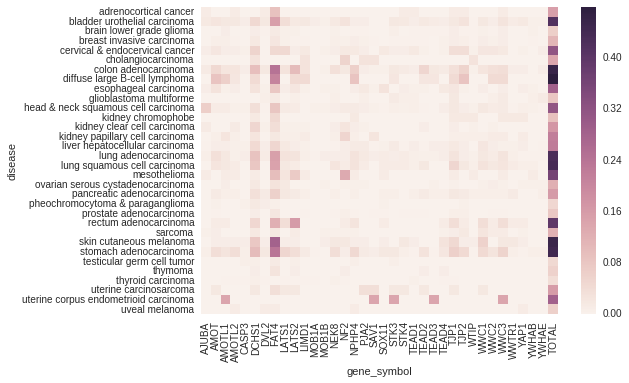

In [16]:
# What is the percentage of different mutations across different cancer types?
sns.heatmap(heatmap_df);

Visualizing the input data here is key. The heterogeneity of the mutations across tissues is apparent for this particular pathway. In comparison with `TP53` mutations, it appears that Hippo signaling impacts different tissues with higher diversity.

Looking closer at the plots above, it is evident that several tissues do not demonstrate aberrations (at least at the mutation level) in Hippo signaling. Specifically, it appears that cancers with gender specificity like testicular cancer and and prostate cancer are _not_ impacted. Therefore, because of this artificial imbalance, if Cognoma were to include these cancers in the classifier, it **will** key in on gender specific signal (i.e. genes that are only on the Y chromosome, or X inactivation genes).  

In [17]:
# How many samples in each tissue that have Hippo signaling aberrations
ind = ['Negatives', 'Positives', 'Positive Prop']
percent = heatmap_df['TOTAL']
neg = y.disease.value_counts() - unique_pos
tissue_summary_df = pd.DataFrame([neg, unique_pos, percent], index=ind, 
                                 dtype='object').T.sort_values('Positive Prop', ascending=False)
tissue_summary_df

,Negatives,Positives,Positive Prop
diffuse large B-cell lymphoma,25,23,0.479167
colon adenocarcinoma,114,96,0.457143
skin cutaneous melanoma,56,47,0.456311
stomach adenocarcinoma,151,121,0.444853
lung squamous cell carcinoma,101,77,0.432584
lung adenocarcinoma,280,207,0.425051
bladder urothelial carcinoma,227,163,0.417949
rectum adenocarcinoma,49,32,0.395062
mesothelioma,53,30,0.361446
cervical & endocervical cancer,132,61,0.316062


## Filter Data by Tissue

This is a crucial step that is different from previous classifiers

In [18]:
# Technically, these are hyper parameters, but for simplicity, set here
filter_prop = 0.10
filter_count = 15

tissue_prop_decision = tissue_summary_df['Positive Prop'] >= filter_prop
tissue_count_decision = tissue_summary_df['Positives'] >= filter_count

tissue_decision = tissue_prop_decision & tissue_count_decision

In [19]:
# This criteria filters out the following tissues
pd.Series(tissue_summary_df.index[~tissue_decision].sort_values())

0                     adrenocortical cancer
1                  brain lower grade glioma
2                        cholangiocarcinoma
3                   glioblastoma multiforme
4                        kidney chromophobe
5          pheochromocytoma & paraganglioma
6                   prostate adenocarcinoma
7                testicular germ cell tumor
8                                   thymoma
9                         thyroid carcinoma
10                   uterine carcinosarcoma
11    uterine corpus endometrioid carcinoma
12                           uveal melanoma
dtype: object

In [20]:
# What are the tissues remaining?
tissue_summary_df = tissue_summary_df[tissue_decision]
tissue_summary_df

,Negatives,Positives,Positive Prop
diffuse large B-cell lymphoma,25,23,0.479167
colon adenocarcinoma,114,96,0.457143
skin cutaneous melanoma,56,47,0.456311
stomach adenocarcinoma,151,121,0.444853
lung squamous cell carcinoma,101,77,0.432584
lung adenocarcinoma,280,207,0.425051
bladder urothelial carcinoma,227,163,0.417949
rectum adenocarcinoma,49,32,0.395062
mesothelioma,53,30,0.361446
cervical & endocervical cancer,132,61,0.316062


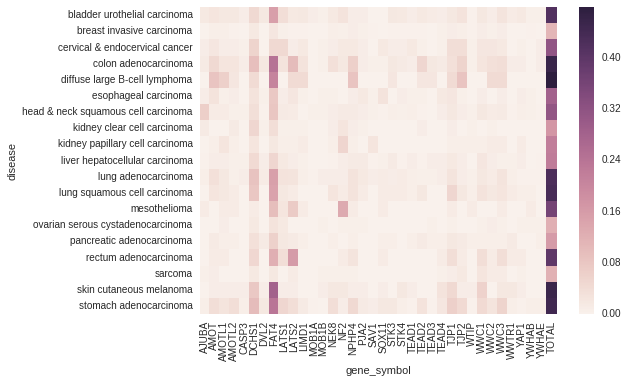

In [21]:
# Distribution of mutation counts after filtering
sns.heatmap(heatmap_df.loc[tissue_decision]);

In [22]:
# Subset data
clinical_sub = clinical[clinical['disease'].isin(tissue_summary_df.index)]
X_sub = X.ix[clinical_sub.index]
y_sub = y['indicator'].ix[clinical_sub.index]

In [23]:
# Total distribution of positives/negatives
y_sub.value_counts(True)

0    0.721539
1    0.278461
Name: indicator, dtype: float64

In [24]:
y_sub.head(7)

sample_id
TCGA-04-1348-01    0
TCGA-04-1357-01    0
TCGA-04-1362-01    0
TCGA-05-4244-01    0
TCGA-05-4249-01    1
TCGA-05-4250-01    0
TCGA-05-4382-01    1
Name: indicator, dtype: int64

## Set aside 10% of the data for testing

In [25]:
strat = clinical_sub['disease'].str.cat(y_sub.astype(str))
strat.head(6)

sample_id
TCGA-04-1348-01    ovarian serous cystadenocarcinoma0
TCGA-04-1357-01    ovarian serous cystadenocarcinoma0
TCGA-04-1362-01    ovarian serous cystadenocarcinoma0
TCGA-05-4244-01                  lung adenocarcinoma0
TCGA-05-4249-01                  lung adenocarcinoma1
TCGA-05-4250-01                  lung adenocarcinoma0
Name: disease, dtype: object

In [26]:
# Make sure the splits have equal tissue and label partitions
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.1, random_state=0,
                                                    stratify=strat)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X_sub.columns),
                                                                          len(X_train), len(X_test))

'Size: 20,530 features, 4,536 training samples, 506 testing samples'

## Median absolute deviation feature selection

In [27]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline and Cross validation model fitting

In [28]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [29]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

CPU times: user 1min 51s, sys: 4.04 s, total: 1min 55s
Wall time: 2min 54s


In [30]:
clf_grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

In [31]:
best_clf

SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.1, learning_rate='optimal',
       loss='log', n_iter=5, n_jobs=1, penalty='elasticnet', power_t=0.5,
       random_state=0, shuffle=True, verbose=0, warm_start=False)

## Visualize hyperparameters performance

In [32]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [33]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,alpha,fold,l1_ratio,score
0,0.000001,0,0.0,0.617272
1,0.000001,1,0.0,0.619249


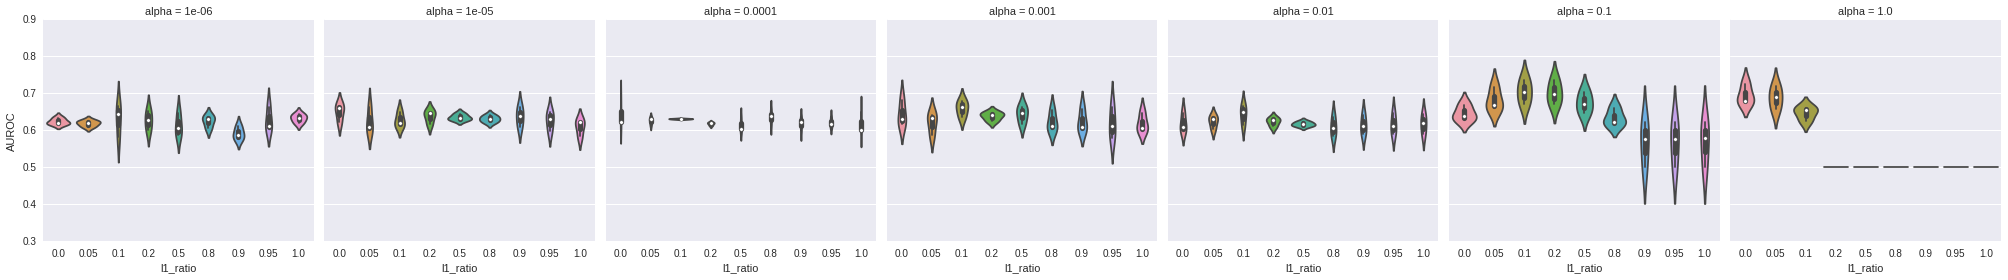

In [34]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='l1_ratio', y='score', col='alpha',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

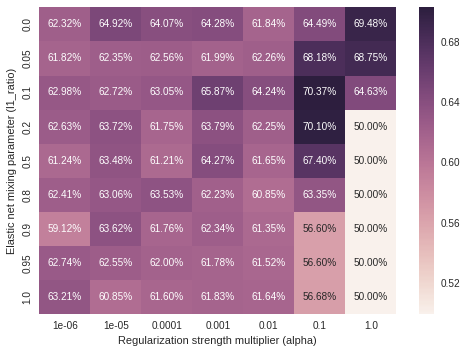

In [35]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.2%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [36]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred, tissue='all'):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df, 'tissue': tissue}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

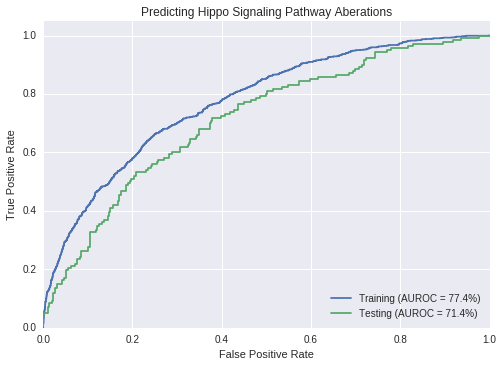

In [37]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting Hippo Signaling Pathway Aberations')
plt.legend(loc='lower right');

## Tissue specific performance

In [38]:
tissue_metrics = {}
for tissue in clinical_sub.disease.unique():
    sample_sub = clinical_sub[clinical_sub['disease'] == tissue].index.values

    y_tissue_train = y_train[y_train.index.isin(sample_sub)]
    y_tissue_pred_train = y_pred_train[y_train.index.isin(sample_sub)]
    y_tissue_test = y_test[y_test.index.isin(sample_sub)]
    y_tissue_pred_test = y_pred_test[y_test.index.isin(sample_sub)]

    metrics_train = get_threshold_metrics(y_tissue_train, y_tissue_pred_train, tissue=tissue)
    metrics_test = get_threshold_metrics(y_tissue_test, y_tissue_pred_test, tissue=tissue) 
    
    tissue_metrics[tissue] = [metrics_train, metrics_test]

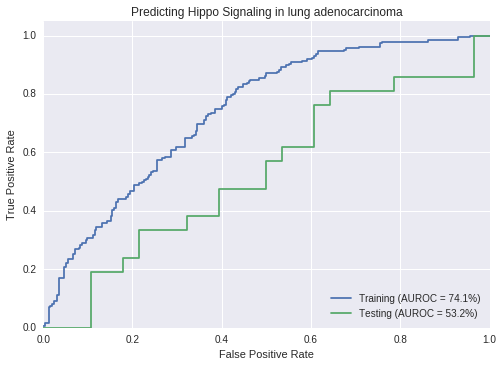

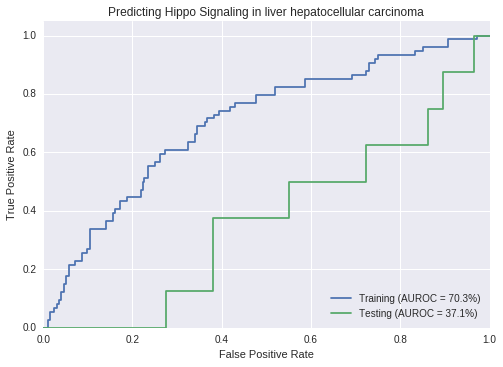

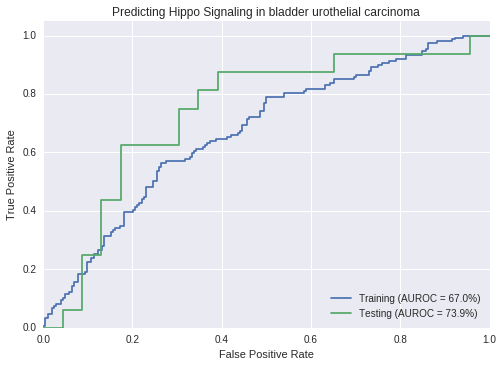

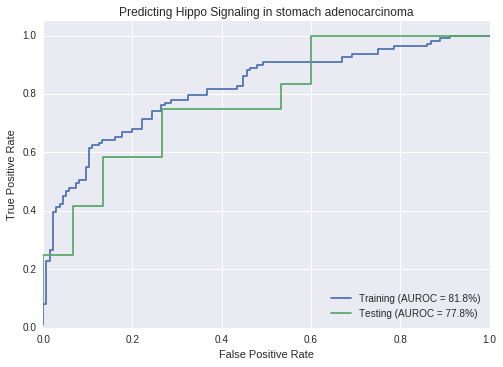

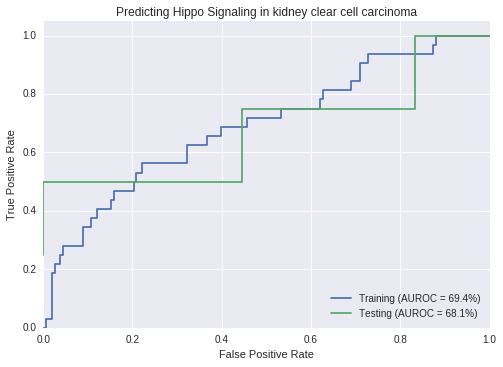

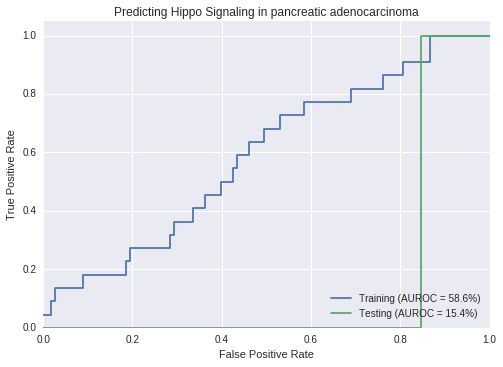

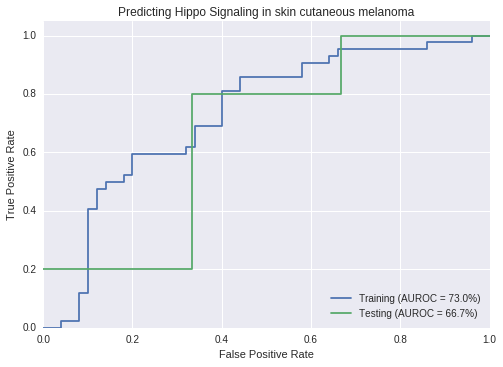

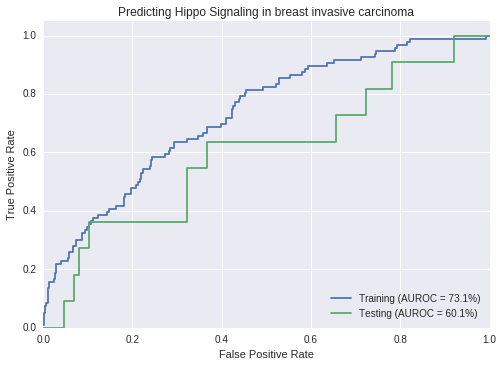

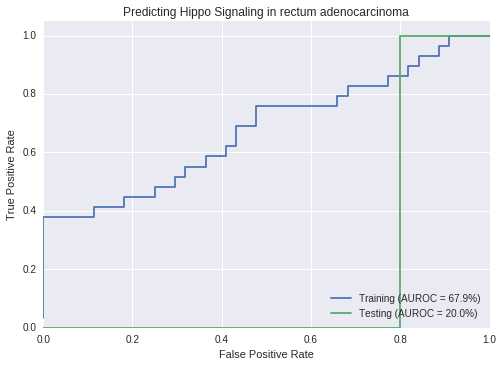

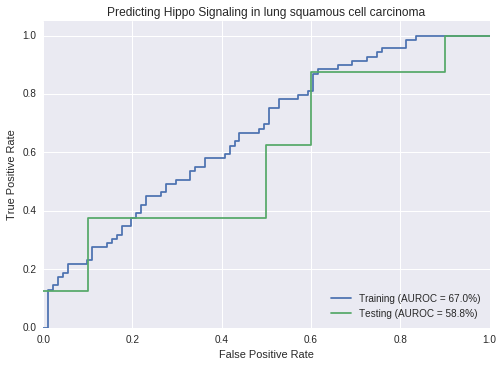

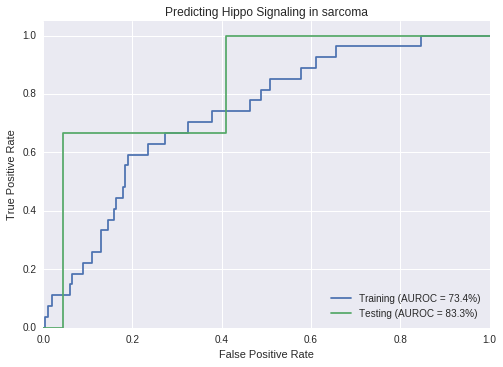

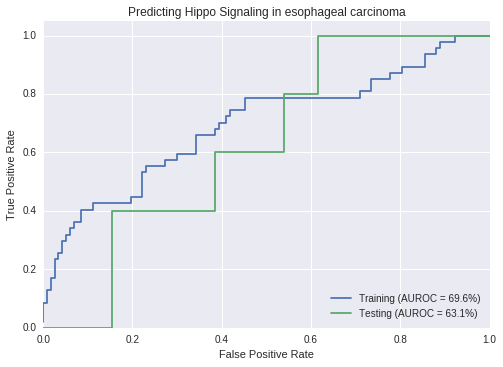

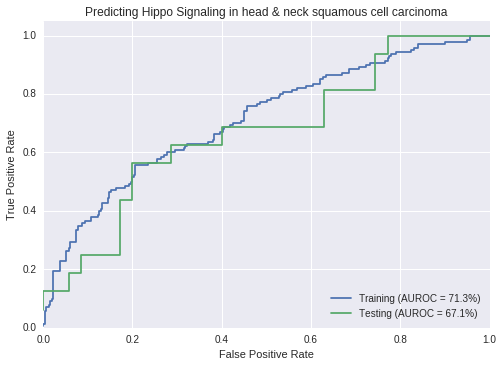

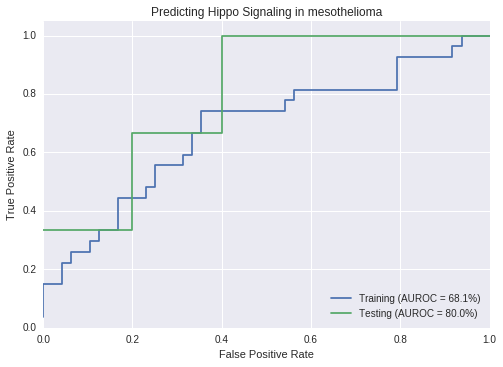

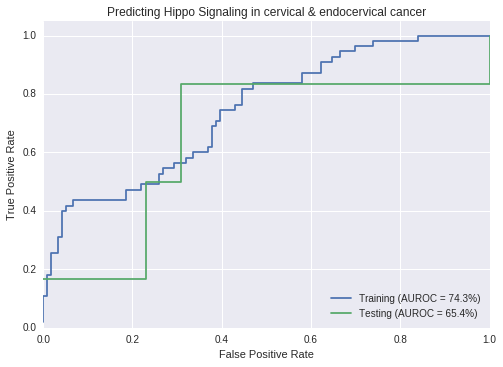

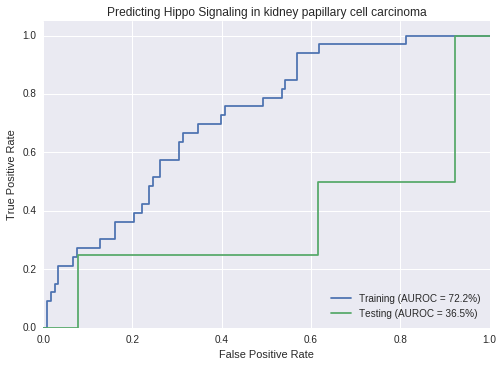

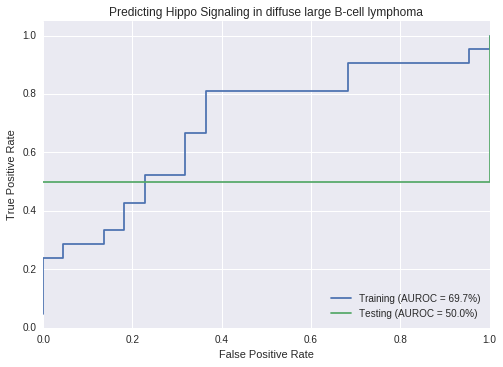

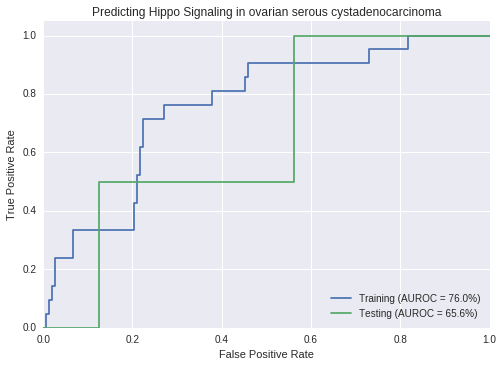

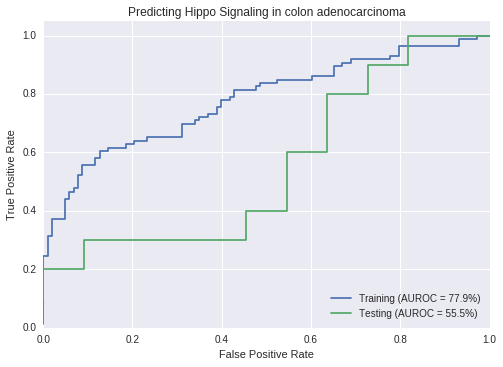

In [39]:
tissue_auroc = {}
plt.figure()
for tissue, metrics_val in tissue_metrics.items():
    metrics_train, metrics_test = metrics_val
    plt.subplot()
    auroc = []
    for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
        roc_df = metrics['roc_df']
        auroc.append(metrics['auroc'])
        plt.plot(roc_df.fpr, roc_df.tpr,
            label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
    tissue_auroc[tissue] = auroc
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Predicting Hippo Signaling in {}'.format(tissue))
    plt.legend(loc='lower right'); 
    plt.show()

In [40]:
tissue_results = pd.DataFrame(tissue_auroc, index=['Train', 'Test']).T
tissue_results = tissue_results.sort_values('Test', ascending=False)

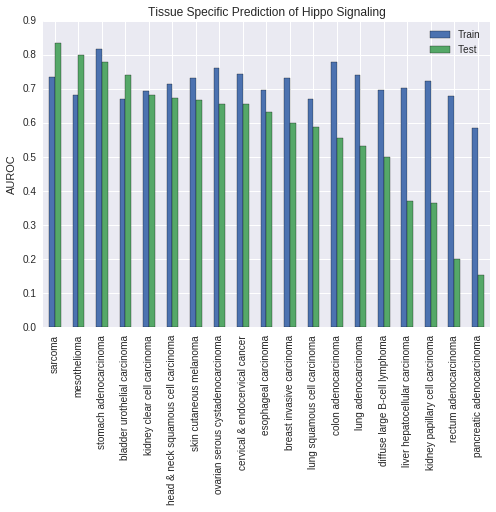

In [41]:
ax = tissue_results.plot(kind='bar', title='Tissue Specific Prediction of Hippo Signaling')
ax.set_ylabel('AUROC');

Hippo signaling prediction has highly variable predictions across different tissues. The classifier performs spectacularly in several tissues, but also appears to oppositely predict Hippo signaling in others. In three tissues the `test` set performance is actually _greater_ than the `train` set performance. This is likely a result of variance in samples across tissues and a happenstance in stratified `train_test_split`.

## What are the classifier coefficients?

In [42]:
coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X_sub.columns[feature_mask], columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [43]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'97.4% zero coefficients; 118 negative and 92 positive coefficients'

In [44]:
coef_df.head(10)

,weight,abs
399671,-0.064672,0.064672
29126,0.061237,0.061237
2852,-0.060303,0.060303
140730,-0.057160,0.057160
84688,0.056350,0.056350
387628,0.048214,0.048214
4438,0.047826,0.047826
80350,-0.047799,0.047799
56892,-0.047692,0.047692
22943,-0.045938,0.045938


The results are very interesting. First, only 200 genes are used to build a fairly successful classifier. Biologists like sparsity! Second, the genes that fall out at the top are informative:

| Entrez | Symbol | Comments |
| ------ | ---- | -------- |
| 399671 | [HEATR4](http://www.ncbi.nlm.nih.gov/gene/399671) | Relatively unstudied gene |
| 29126 | [CD274](http://www.ncbi.nlm.nih.gov/gene/29126) | Immune cell receptor - inhibits Tcell activation and cytokine production |
| 2852 | [GPER1](http://www.ncbi.nlm.nih.gov/gene/2852) | Estrogen receptor - implicated in lymphoma |
| 140730 | [RIMS4](http://www.ncbi.nlm.nih.gov/gene/140730) | Synaptic regulatory protein |
| 84688 | [C9orf24](http://www.ncbi.nlm.nih.gov/gene/84688) | relatively unknown gene - important for differentiation of bronchial cells |
| 387628 | [FGF7P6](http://www.ncbi.nlm.nih.gov/gene/387628) | Fibroblast growth factor - implicated in ovarian cancer |
| 4438 | [MSH4](http://www.ncbi.nlm.nih.gov/gene/4438) | Involved in DNA mismatch repair |
| 80350 | [LPAL2](http://www.ncbi.nlm.nih.gov/gene/157777) | Pseudogene involved with elevated risk for atherosclerosis |
| 56892 | [C8orf4](http://www.ncbi.nlm.nih.gov/gene/56892) | Relatively uknown gene product - evidence it is important in WNT signaling and proliferation across cancer types |
| 22943 | [DKK1](http://www.ncbi.nlm.nih.gov/gene/22943) | Inhibits WNT signaling pathway - implicated in myeloma |



## Investigate the predictions

In [45]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X_sub.index),
    ('testing', X_sub.index.isin(X_test.index).astype(int)),
    ('status', y_sub),
    ('decision_function', pipeline.decision_function(X_sub)),
    ('probability', pipeline.predict_proba(X_sub)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [46]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-37-4133-01,TCGA-37-4133-01,0,0,1.679050,0.842779,84.3%
TCGA-BR-7707-01,TCGA-BR-7707-01,0,0,1.674772,0.842211,84.2%
TCGA-DK-A1A6-01,TCGA-DK-A1A6-01,0,0,1.632387,0.836496,83.6%
TCGA-55-7570-01,TCGA-55-7570-01,0,0,1.460996,0.811685,81.2%
TCGA-86-8672-01,TCGA-86-8672-01,0,0,1.420436,0.805407,80.5%
TCGA-BR-4253-01,TCGA-BR-4253-01,0,0,1.380836,0.799125,79.9%
TCGA-05-4418-01,TCGA-05-4418-01,1,0,1.354113,0.794801,79.5%
TCGA-HU-8604-01,TCGA-HU-8604-01,0,0,1.321669,0.789459,78.9%
TCGA-69-8255-01,TCGA-69-8255-01,0,0,1.309655,0.787455,78.7%


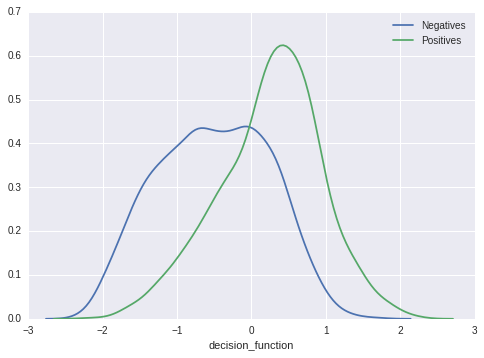

In [47]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

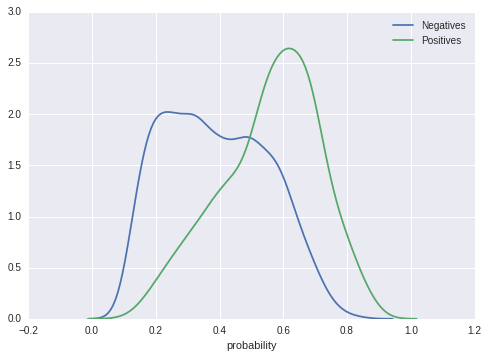

In [48]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')